In [1]:
import pandas as pd
import statistics
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import statistics as stat
from scipy.stats import binom
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Rectangle
# splitting merge_data into train test and split
from sklearn.model_selection import train_test_split, cross_validate
from scipy import stats
from scipy.stats import normaltest
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import matplotlib as mpl
import warnings; warnings.filterwarnings(action='once')
# to keep track of training time
import datetime
# logistic regression model
from sklearn.linear_model import LogisticRegression
# metrics used for evaluation
from sklearn.metrics import f1_score, matthews_corrcoef
# visualizations
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix
from sklearn.metrics import plot_roc_curve
# KNN imputation
from sklearn.impute import KNNImputer
# normalizer
from sklearn.preprocessing import Normalizer
# variance threshold
from sklearn.feature_selection import VarianceThreshold
# RFECV
from sklearn.model_selection import StratifiedKFold
# random forest
from sklearn.ensemble import RandomForestClassifier
# evaluation metric
from sklearn.metrics import matthews_corrcoef, make_scorer
from scipy import stats 
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split 
from sklearn.model_selection import cross_val_score # Evaluate a score by cross-validation
from sklearn.model_selection import GridSearchCV # Exhaustive search over specified parameter values for an estimator
from sklearn.metrics import classification_report # Build a text report showing the main classification metrics
from sklearn.metrics import accuracy_score # Accuracy classification score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # to show confusion matrix
from sklearn import metrics # Evaluate ROC curve
from sklearn.experimental import enable_iterative_imputer # Enables IterativeImputer. The API and results of this estimator might change without any deprecation cycle
from sklearn.impute import IterativeImputer
from imblearn.combine import SMOTEENN # Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours
from sklearn import decomposition
from boruta import BorutaPy
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import plot_confusion_matrix
from matplotlib.colors import ListedColormap

Read files 

In [2]:
def read_secom():
    path ='C:/Users/duygu/OneDrive/Documents/VS_CODE_REPOS/Fault-Detection-SECOM/secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature'+str(x+1) for x in range(len(df.columns))]
    return df

#%%
def read_labels():
    path = 'C:/Users/duygu/OneDrive/Documents/VS_CODE_REPOS/Fault-Detection-SECOM/secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df

#read 2 df 
df_features = read_secom()
df_target = read_labels()

# Data Preparation

## Merge data

In [3]:
df= pd.concat([df_features,df_target],axis=1)

## Split Training and test data 

In [4]:
x = df.iloc[:,:590]
y = df.iloc[:,590]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1,stratify=y)

In [5]:
x_train.isna().sum().sum()

33219

## reducing dimensionality 

### remove missing values 

In [6]:
def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

In [7]:
x_train_na = null_values(x_train)
x_train_na

,Missing_Records,Percentage (%)
feature293,1144,91.300878
feature158,1144,91.300878
feature159,1144,91.300878
feature294,1144,91.300878
feature221,1072,85.554669
...,...,...
feature500,1,0.079808
feature367,1,0.079808
feature377,1,0.079808
feature378,1,0.079808


In [8]:
miss_threshold=80
x_train_na= x_train_na[x_train_na["Percentage (%)"] > miss_threshold]
x_train_na

,Missing_Records,Percentage (%)
feature293,1144,91.300878
feature158,1144,91.300878
feature159,1144,91.300878
feature294,1144,91.300878
feature221,1072,85.554669
feature86,1072,85.554669
feature359,1072,85.554669
feature493,1072,85.554669


In [9]:
x_train_new = x_train.drop(axis=1, columns=x_train_na.index)
x_train_new.shape

(1253, 582)

### removing constant voltality

In [10]:
x_train_new_eda= x_train_new.describe().T
x_train_new_eda

,count,mean,std,min,25%,50%,75%,max
feature1,1248.0,3014.113686,73.877303,2743.2400,2966.2300,3011.40500,3056.310000,3356.3500
feature2,1247.0,2496.400585,79.188651,2162.8700,2452.3350,2500.38000,2539.600000,2846.4400
feature3,1243.0,2200.216525,29.939025,2060.6600,2180.8611,2200.98890,2218.055500,2315.2667
feature4,1243.0,1394.907987,436.632421,0.0000,1083.8858,1283.43680,1593.122000,3715.0417
feature5,1243.0,4.018582,54.572445,0.6815,1.0160,1.31710,1.525700,1114.5366
...,...,...,...,...,...,...,...,...
feature586,1252.0,3.084501,3.968128,1.1975,2.3058,2.74655,3.258475,99.3032
feature587,1252.0,0.021521,0.012421,-0.0060,0.0134,0.02070,0.027600,0.1028
feature588,1252.0,0.016344,0.008698,0.0042,0.0106,0.01480,0.019800,0.0799
feature589,1252.0,0.005248,0.002850,0.0012,0.0033,0.00460,0.006300,0.0286


In [11]:
x_train_new_eda[x_train_new_eda['std']==0]
x_train_new_std= x_train_new_eda[x_train_new_eda["std"] == 0]
x_train_new_std

,count,mean,std,min,25%,50%,75%,max
feature6,1243.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0
feature14,1251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature43,1253.0,70.0,0.0,70.0,70.0,70.0,70.0,70.0
feature50,1253.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
feature53,1253.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
feature535,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature536,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature537,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature538,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
x_train_new_2 = x_train_new.drop(axis=1, columns=x_train_new_std.index)
x_train_new_2.shape

(1253, 466)

## Outlier Treatment

In [13]:
x_train_3s=x_train_new_2.copy()

In [14]:
def zscore(df,cols,thr):
    for col in cols:
        mean=df[col].mean()
        std=df[col].std()
        upper_bound=mean+ thr*std
        lower_bound=mean- thr*std
        df[col]=np.where(df[col]>upper_bound,upper_bound,np.where(df[col]<lower_bound,lower_bound,df[col]))

In [15]:
zscore(x_train_3s,x_train_3s.columns,3)

# Checking

In [16]:
x_train_new_2['feature4'].mean()

1394.907986725665

In [17]:

x_train_new_2['feature4'].std()

436.63242083048897

In [18]:
x_train_new_2['feature4'].mean()+3*x_train_new_2['feature4'].std()

2704.805249217132

In [19]:
x_train_new_2['feature4'].max()

3715.0417

In [20]:
x_train_3s['feature4'].max()


2704.805249217132

## Imputation

### KNN Imputation

In [21]:
#scaling before distanced based algo
scaler = MinMaxScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_3s), columns=x_train_3s.columns)
x_train_scaled

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,0.648120,0.201366,0.538010,0.452172,0.006439,0.392017,0.787343,0.527160,0.680406,0.663699,...,0.345437,0.190010,0.514663,0.075172,0.110693,0.071958,0.527907,0.397495,0.373085,0.182951
1,0.471228,0.489118,0.250017,0.318042,0.003555,0.606695,0.806973,0.430272,0.451391,0.514345,...,NaN,NaN,0.224461,0.208979,0.166039,0.205512,0.353482,0.611932,0.547721,0.436456
2,0.564671,0.250573,0.351025,0.514797,0.002089,0.753605,0.865862,0.613416,0.734617,0.735677,...,NaN,NaN,0.319527,0.081186,0.110693,0.079049,0.413682,0.640698,0.627101,0.368023
3,0.510211,0.300896,0.632400,0.543962,0.005265,0.467181,0.715366,0.483910,0.387223,0.678095,...,0.191093,0.137507,0.744823,0.061641,0.089938,0.057659,0.530994,0.258894,0.206388,0.132398
4,0.513934,0.368646,0.597947,0.633548,0.001678,0.476510,0.777528,0.610033,0.401606,0.399181,...,NaN,NaN,0.559694,0.130800,0.124529,0.125897,0.347307,0.188287,0.246077,0.183597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,0.597451,0.468702,0.581926,0.602601,0.002028,0.483641,0.872406,0.581040,0.146039,0.582724,...,NaN,NaN,0.694788,0.172896,0.145284,0.165038,0.498579,0.196132,0.166698,0.118079
1249,0.490065,0.645495,0.636173,0.467074,0.004245,0.502029,0.744811,0.486810,0.421520,0.359593,...,NaN,NaN,0.404586,0.027062,0.041510,0.027184,0.517102,0.452412,0.508031,0.207902
1250,0.545630,0.784278,0.382138,0.741741,0.005230,0.349415,0.829874,0.448393,0.563133,0.661900,...,NaN,NaN,0.349548,0.102234,0.117611,0.100454,0.552604,0.193517,0.214325,0.103733
1251,0.525033,0.514521,0.385973,1.000000,0.004806,0.000000,0.875677,0.304874,0.431477,0.436969,...,0.029399,0.127442,0.604725,0.147337,0.172957,0.141052,0.277846,0.033996,0.031752,0.122707


In [22]:
# impute missing values and save it as a temporary dataset.
# no need to use scalr before applying teh KNN model , fit_transform fits and scales automatically
#use fit_transform on training data and only transform on test data
knn = KNNImputer()
#knn.fit(x_train_scaled)
#imputed_train = pd.DataFrame(knn.fit_transform(x_train_3s), columns = x_train_3s.columns)
imputed_train = pd.DataFrame(knn.fit_transform(x_train_scaled), columns = x_train_scaled.columns)

# Checking

In [23]:
imputed_train.isna().sum().sum()

0

In [24]:
imputed_train

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,0.648120,0.201366,0.538010,0.452172,0.006439,0.392017,0.787343,0.527160,0.680406,0.663699,...,0.345437,0.190010,0.514663,0.075172,0.110693,0.071958,0.527907,0.397495,0.373085,0.182951
1,0.471228,0.489118,0.250017,0.318042,0.003555,0.606695,0.806973,0.430272,0.451391,0.514345,...,0.423344,0.230365,0.224461,0.208979,0.166039,0.205512,0.353482,0.611932,0.547721,0.436456
2,0.564671,0.250573,0.351025,0.514797,0.002089,0.753605,0.865862,0.613416,0.734617,0.735677,...,0.277819,0.172041,0.319527,0.081186,0.110693,0.079049,0.413682,0.640698,0.627101,0.368023
3,0.510211,0.300896,0.632400,0.543962,0.005265,0.467181,0.715366,0.483910,0.387223,0.678095,...,0.191093,0.137507,0.744823,0.061641,0.089938,0.057659,0.530994,0.258894,0.206388,0.132398
4,0.513934,0.368646,0.597947,0.633548,0.001678,0.476510,0.777528,0.610033,0.401606,0.399181,...,0.236661,0.336388,0.559694,0.130800,0.124529,0.125897,0.347307,0.188287,0.246077,0.183597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,0.597451,0.468702,0.581926,0.602601,0.002028,0.483641,0.872406,0.581040,0.146039,0.582724,...,0.217552,0.130255,0.694788,0.172896,0.145284,0.165038,0.498579,0.196132,0.166698,0.118079
1249,0.490065,0.645495,0.636173,0.467074,0.004245,0.502029,0.744811,0.486810,0.421520,0.359593,...,0.249890,0.155535,0.404586,0.027062,0.041510,0.027184,0.517102,0.452412,0.508031,0.207902
1250,0.545630,0.784278,0.382138,0.741741,0.005230,0.349415,0.829874,0.448393,0.563133,0.661900,...,0.318978,0.106352,0.349548,0.102234,0.117611,0.100454,0.552604,0.193517,0.214325,0.103733
1251,0.525033,0.514521,0.385973,1.000000,0.004806,0.000000,0.875677,0.304874,0.431477,0.436969,...,0.029399,0.127442,0.604725,0.147337,0.172957,0.141052,0.277846,0.033996,0.031752,0.122707


In [25]:
retransformed_train= pd.DataFrame(scaler.inverse_transform(imputed_train), columns=imputed_train.columns)

In [26]:
retransformed_train

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,3079.77,2354.51,2207.0444,1269.607800,1.7571,97.018900,0.1221,1.4607,0.0155,0.0093,...,0.00590,68.74440,0.5001,0.0110,0.0034,2.1899,0.0282,0.0194,0.0059,68.7444
1,3001.36,2491.23,2155.3111,918.216100,1.2753,105.047800,0.1227,1.4206,-0.0052,0.0010,...,0.00696,83.34452,0.4943,0.0199,0.0042,4.0318,0.0169,0.0276,0.0081,163.9998
2,3042.78,2377.89,2173.4556,1433.673200,1.0304,110.542200,0.1245,1.4964,0.0204,0.0133,...,0.00498,62.24328,0.4962,0.0114,0.0034,2.2877,0.0208,0.0287,0.0091,138.2861
3,3018.64,2401.80,2224.0000,1510.079700,1.5611,99.830000,0.1199,1.4428,-0.0110,0.0101,...,0.00380,49.74900,0.5047,0.0101,0.0031,1.9927,0.0284,0.0141,0.0038,49.7490
4,3020.29,2433.99,2217.8111,1744.777100,0.9618,100.178900,0.1218,1.4950,-0.0097,-0.0054,...,0.00442,121.70308,0.5010,0.0147,0.0036,2.9338,0.0165,0.0114,0.0043,68.9871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,3057.31,2481.53,2214.9333,1663.702400,1.0203,100.445600,0.1247,1.4830,-0.0328,0.0048,...,0.00416,47.12526,0.5037,0.0175,0.0039,3.4736,0.0263,0.0117,0.0033,44.3686
1249,3009.71,2565.53,2224.6778,1308.647900,1.3907,101.133300,0.1208,1.4440,-0.0079,-0.0076,...,0.00460,56.27146,0.4979,0.0078,0.0024,1.5724,0.0275,0.0215,0.0076,78.1199
1250,3034.34,2631.47,2179.0445,2028.220800,1.5552,95.425600,0.1234,1.4281,0.0049,0.0092,...,0.00554,38.47760,0.4968,0.0128,0.0035,2.5829,0.0298,0.0116,0.0039,38.9781
1251,3025.21,2503.30,2179.7333,2704.805249,1.4843,82.357569,0.1248,1.3687,-0.0070,-0.0033,...,0.00160,46.10760,0.5019,0.0158,0.0043,3.1428,0.0120,0.0055,0.0016,46.1076


## Feature Selection

In [27]:
#NOTE: no need to retransform /unscale
#retransformed_train= pd.DataFrame(scaler.inverse_transform(imputed_train), columns=imputed_train.columns)

Boruta

In [249]:
#Boruta function with random forest

def BorutaFeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
    model.fit(X, y)
    
    # define Boruta feature selection method
    feature_selector = BorutaPy(model, n_estimators='auto', verbose=0, random_state=100, max_iter=150)

    # find all relevant features
    feature_selector.fit(X.to_numpy(),y)

    # check selected features
    feature_selector.support_

    # check ranking of features
    feature_ranking=feature_selector.ranking_

    # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             feature_selector.ranking_, 
                             feature_selector.support_))

    # print the results
    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 1)
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    print(final_features)
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features)) , final_features, feature_ranking

In [250]:
# apply Boruta and store selected features in a variable
#X_train , final_features = BorutaFeatureSelection(imputed_train,y_train,145)
# boruta on reversed scaled data 
X_train , final_features, feature_ranking = BorutaFeatureSelection(retransformed_train,y_train)

Feature: feature1                       Rank: 3,  Keep: False
Feature: feature2                       Rank: 358,  Keep: False
Feature: feature3                       Rank: 260,  Keep: False
Feature: feature4                       Rank: 132,  Keep: False
Feature: feature5                       Rank: 436,  Keep: False
Feature: feature7                       Rank: 281,  Keep: False
Feature: feature8                       Rank: 227,  Keep: False
Feature: feature9                       Rank: 71,  Keep: False
Feature: feature10                      Rank: 352,  Keep: False
Feature: feature11                      Rank: 154,  Keep: False
Feature: feature12                      Rank: 102,  Keep: False
Feature: feature13                      Rank: 302,  Keep: False
Feature: feature15                      Rank: 104,  Keep: False
Feature: feature16                      Rank: 262,  Keep: False
Feature: feature17                      Rank: 60,  Keep: False
Feature: feature18                      Rank

In [251]:
X_train

,feature20,feature22,feature34,feature60,feature122,feature130,feature131,feature206,feature248,feature342,feature349,feature427,feature478,feature520
0,12.3686,-4750.75,8.6915,0.6991,15.76,0.0000,0.8203,9.22,0.015200,2.6547,0.02370,1.3155,6.0266,3.292400
1,12.4959,-5410.75,8.3006,-1.4173,15.76,0.2838,0.8291,7.31,0.031060,2.0989,0.02720,0.6593,4.8218,6.713220
2,12.5553,-6456.75,8.7418,10.2355,15.65,-0.2838,0.5438,8.80,0.034500,2.5012,0.01630,1.5403,6.1589,7.439200
3,12.4469,-5775.00,8.6829,9.8518,15.73,0.0473,0.8048,7.77,0.260816,2.4329,0.03000,1.6422,5.0612,61.263283
4,12.4618,-6900.50,8.5891,1.0336,15.90,0.4258,0.7611,11.06,0.017220,3.2653,0.02430,0.8006,7.4828,3.731840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,12.4824,-6451.75,9.1156,3.2964,15.96,-0.9461,0.7527,6.83,0.018680,1.8996,0.02640,0.9383,4.6390,4.053080
1249,12.5280,-5470.25,8.4278,3.0345,15.79,-0.4258,0.7217,9.58,0.020300,2.7085,0.01830,0.5571,6.6740,4.373000
1250,12.6278,-5972.75,8.5155,11.4855,15.94,0.5677,0.8380,9.74,0.138300,3.1945,0.02680,1.8298,6.3958,29.569300
1251,12.5373,-5735.25,9.0650,-2.3109,15.69,0.0000,0.5768,6.56,0.020880,1.9995,0.02386,1.4074,4.3482,4.550960


<AxesSubplot:>

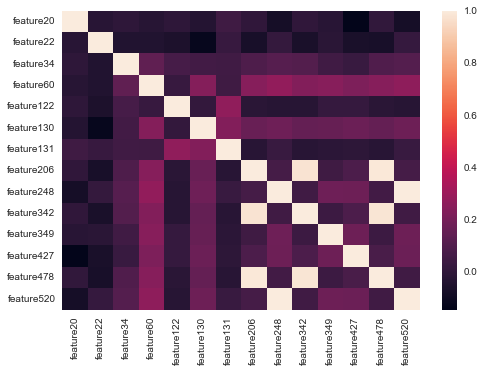

In [252]:
X_train.corr()
sns.heatmap(X_train.corr())

In [253]:
from xgboost import XGBClassifier
import xgboost as xgb

RFE

In [254]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

In [255]:
#RFE function with Rnadomforest

def RFEFeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample',max_depth=5, random_state=100)
    model.fit(X, y)

    # define RFE feature selection method
    rfe = RFE(estimator = model,n_features_to_select = 20)

    # find all relevant features
    rfe.fit(X,y)

    # check selected features
    rfe.support_

    # check ranking of features
    rfe.ranking_

    # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             rfe.ranking_, 
                             rfe.support_))

    # print the results
    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features_rfe = list()
    indexes = np.where(rfe.ranking_ <= 1)
    for x in np.nditer(indexes):
        final_features_rfe.append(feature_names[x])
    print(final_features_rfe)
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features_rfe)) , final_features_rfe

In [256]:
# apply RFE and store selected features in a variable
X_train_rfe, final_features_rfe = RFEFeatureSelection(imputed_train,y_train)

Feature: feature1                       Rank: 1,  Keep: True
Feature: feature2                       Rank: 342,  Keep: False
Feature: feature3                       Rank: 97,  Keep: False
Feature: feature4                       Rank: 339,  Keep: False
Feature: feature5                       Rank: 208,  Keep: False
Feature: feature7                       Rank: 249,  Keep: False
Feature: feature8                       Rank: 265,  Keep: False
Feature: feature9                       Rank: 23,  Keep: False
Feature: feature10                      Rank: 143,  Keep: False
Feature: feature11                      Rank: 282,  Keep: False
Feature: feature12                      Rank: 231,  Keep: False
Feature: feature13                      Rank: 207,  Keep: False
Feature: feature15                      Rank: 72,  Keep: False
Feature: feature16                      Rank: 416,  Keep: False
Feature: feature17                      Rank: 68,  Keep: False
Feature: feature18                      Rank: 2

<AxesSubplot:>

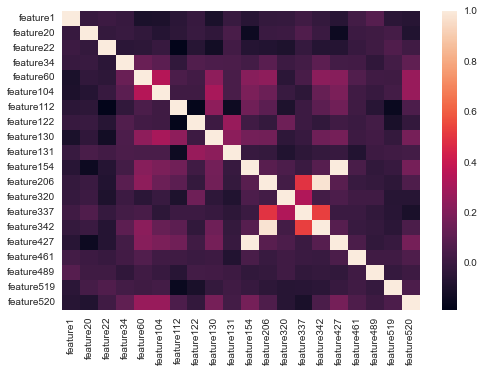

In [257]:
X_train_rfe.corr()
sns.heatmap(X_train_rfe.corr())

In [258]:
from sklearn.svm import SVC

In [259]:
#RFE function with SVM
#used scaled data

'def RFESVMFeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    # define SVC CLASSFIER
    model = SVC(kernel='linear',C=5)
    model.fit(X, y)

    # define RFE feature selection method
    rfe = RFE(estimator=model,n_features_to_select=15)

    # find all relevant features
    rfe.fit(X,y)

    # check selected features
    rfe.support_

    # check ranking of features
    rfe.ranking_

    # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             rfe.ranking_, 
                             rfe.support_))

    # print the results
    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features_rfesvm = list()
    indexes = np.where(rfe.ranking_ <= 1)
    for x in np.nditer(indexes):
        final_features_rfesvm.append(feature_names[x])
    print(final_features_rfesvm)
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features_rfesvm)) , final_features_rfesvm

SyntaxError: EOL while scanning string literal (Temp/ipykernel_17272/1522730050.py, line 4)

In [ ]:
# apply RFE and store selected features in a variable
X_train_rfesvm, final_features_rfesvm = RFESVMFeatureSelection(imputed_train,y_train)

Feature: feature1                       Rank: 26,  Keep: False
Feature: feature2                       Rank: 121,  Keep: False
Feature: feature3                       Rank: 108,  Keep: False
Feature: feature4                       Rank: 262,  Keep: False
Feature: feature5                       Rank: 415,  Keep: False
Feature: feature7                       Rank: 117,  Keep: False
Feature: feature8                       Rank: 27,  Keep: False
Feature: feature9                       Rank: 199,  Keep: False
Feature: feature10                      Rank: 106,  Keep: False
Feature: feature11                      Rank: 47,  Keep: False
Feature: feature12                      Rank: 70,  Keep: False
Feature: feature13                      Rank: 271,  Keep: False
Feature: feature15                      Rank: 15,  Keep: False
Feature: feature16                      Rank: 160,  Keep: False
Feature: feature17                      Rank: 182,  Keep: False
Feature: feature18                      Rank:

In [ ]:
final_features_rfesvm

['feature54',
 'feature57',
 'feature60',
 'feature64',
 'feature73',
 'feature111',
 'feature112',
 'feature130',
 'feature250',
 'feature334',
 'feature339',
 'feature425',
 'feature472',
 'feature567',
 'feature569']

Boruta Shap with Rnadom forest 

In [ ]:
feature_selector.fit(X.to_numpy(),y)

In [277]:
from BorutaShap import BorutaShap

In [317]:
#Boruta Shap function with random forest

def BorutaShapFeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)
    modelshap.fit(X,y)
    
    # define Boruta feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure='shap',
                              classification=True)

    # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = True,random_state=100)
    feature_selector.plot(which_features='accepted',figsize=(20,10))
 # call transform() on X to filter it down to selected features
    return  feature_selector.Subset(feature_selector.tentative)


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


18 attributes confirmed important: ['feature478', 'feature124', 'feature65', 'feature66', 'feature349', 'feature342', 'feature60', 'feature299', 'feature206', 'feature133', 'feature435', 'feature332', 'feature283', 'feature461', 'feature164', 'feature442', 'feature22', 'feature34']
447 attributes confirmed unimportant: ['feature128', 'feature62', 'feature92', 'feature136', 'feature87', 'feature23', 'feature82', 'feature203', 'feature253', 'feature104', 'feature229', 'feature160', 'feature481', 'feature84', 'feature550', 'feature457', 'feature460', 'feature304', 'feature383', 'feature519', 'feature430', 'feature172', 'feature10', 'feature200', 'feature27', 'feature212', 'feature311', 'feature579', 'feature46', 'feature340', 'feature279', 'feature441', 'feature351', 'feature29', 'feature117', 'feature497', 'feature420', 'feature184', 'feature336', 'feature209', 'feature47', 'feature317', 'feature21', 'feature110', 'feature36', 'feature121', 'feature350', 'feature391', 'feature558', 'feat

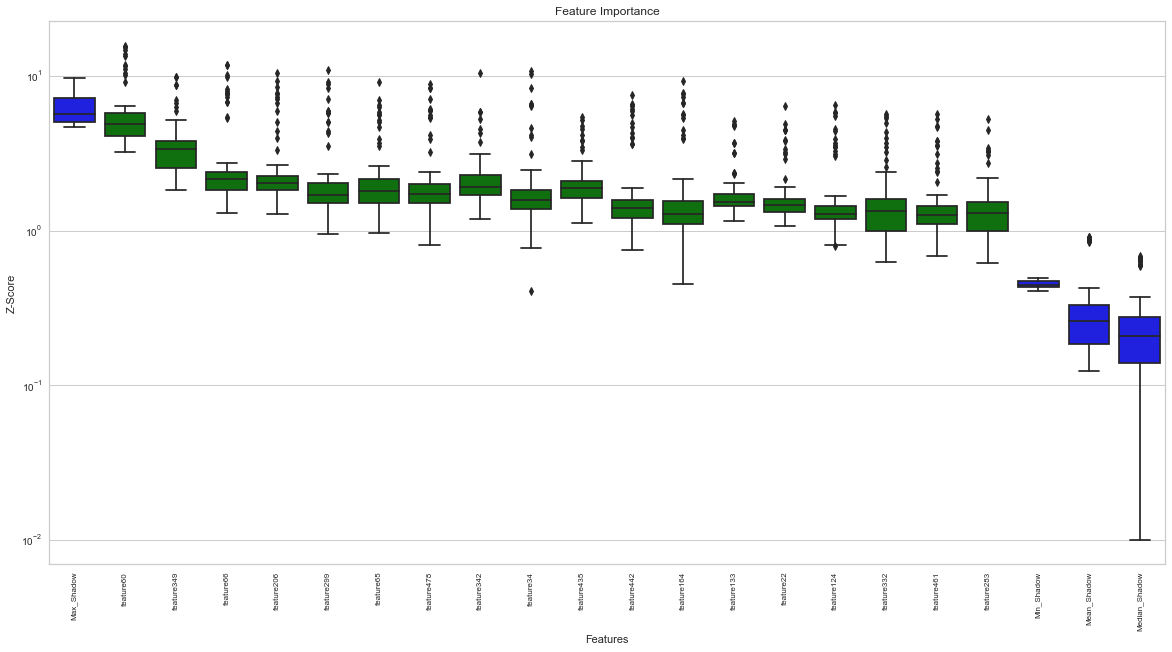

AttributeError: 'list' object has no attribute 'tolist'

In [318]:
X_trainshap= BorutaShapFeatureSelection(retransformed_train,y_train)

In [ ]:
X_trainshap

['feature185']

In [ ]:
'#Boruta Shap function with random forest

def BorutaShapFeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)
    modelshap.fit(X,y)
    
    # define Boruta feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure='shap',
                              classification=True)

    # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = True,random_state=100)
    feature_selector.plot(which_features='accepted',figsize=(20,10))
 # call transform() on X to filter it down to selected features
    return   feature_selector.tentative[col]

100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


18 attributes confirmed important: ['feature478', 'feature124', 'feature65', 'feature66', 'feature349', 'feature342', 'feature60', 'feature299', 'feature206', 'feature133', 'feature435', 'feature332', 'feature283', 'feature461', 'feature164', 'feature442', 'feature22', 'feature34']
447 attributes confirmed unimportant: ['feature128', 'feature62', 'feature92', 'feature136', 'feature87', 'feature23', 'feature82', 'feature203', 'feature253', 'feature104', 'feature229', 'feature160', 'feature481', 'feature84', 'feature550', 'feature457', 'feature460', 'feature304', 'feature383', 'feature519', 'feature430', 'feature172', 'feature10', 'feature200', 'feature27', 'feature212', 'feature311', 'feature579', 'feature46', 'feature340', 'feature279', 'feature441', 'feature351', 'feature29', 'feature117', 'feature497', 'feature420', 'feature184', 'feature336', 'feature209', 'feature47', 'feature317', 'feature21', 'feature110', 'feature36', 'feature121', 'feature350', 'feature391', 'feature558', 'feat

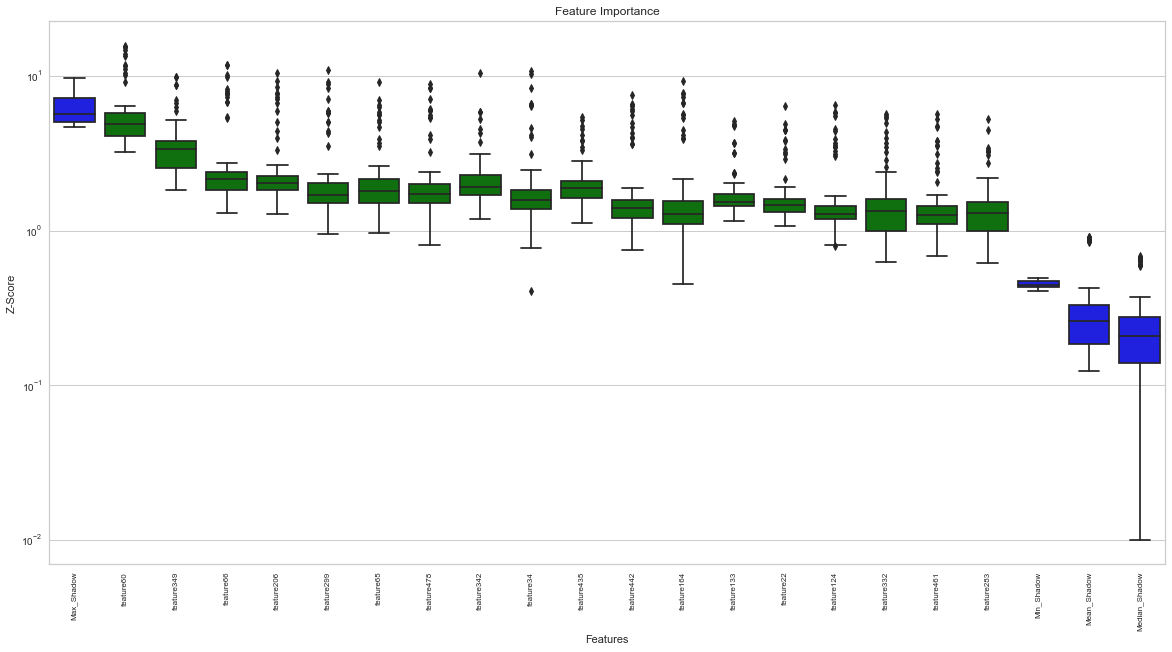

NameError: name 'col' is not defined

In [ ]:
X_trainshap= BorutaShapFeatureSelection(retransformed_train,y_train)

In [ ]:
X_trainshap

['feature185']

In [ ]:
X_trainshap.corr()
sns.heatmap(X_trainshap.corr())

AttributeError: 'list' object has no attribute 'corr'

In [ ]:
#Boruta Shap function with random forest

'def BorutaShapFeatureSelection (X, y) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    modelshap = RandomForestClassifier(n_jobs=-1,n_estimators=100, max_depth=5, random_state=100)
    modelshap.fit(X,y)
    
    # define Boruta feature selection method
    feature_selector = BorutaShap(model=modelshap,
                              importance_measure='gini',
                              classification=True)

    # find all relevant features
    feature_selector.fit(X,y,n_trials=100,sample = False, verbose = True,random_state=100)
    feature_selector.plot(which_features='accepted',figsize=(20,10))
 # call transform() on X to filter it down to selected features
    return  feature_selector.Subset()

100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


11 attributes confirmed important: ['feature154', 'feature65', 'feature66', 'feature427', 'feature349', 'feature299', 'feature60', 'feature133', 'feature461', 'feature3', 'feature442']
455 attributes confirmed unimportant: ['feature128', 'feature62', 'feature92', 'feature136', 'feature87', 'feature23', 'feature82', 'feature203', 'feature253', 'feature104', 'feature229', 'feature160', 'feature481', 'feature84', 'feature550', 'feature457', 'feature460', 'feature304', 'feature383', 'feature519', 'feature430', 'feature172', 'feature10', 'feature200', 'feature27', 'feature212', 'feature311', 'feature579', 'feature46', 'feature340', 'feature279', 'feature441', 'feature351', 'feature478', 'feature29', 'feature117', 'feature497', 'feature420', 'feature184', 'feature336', 'feature209', 'feature47', 'feature317', 'feature21', 'feature110', 'feature36', 'feature121', 'feature350', 'feature391', 'feature558', 'feature13', 'feature88', 'feature40', 'feature290', 'feature174', 'feature378', 'feature

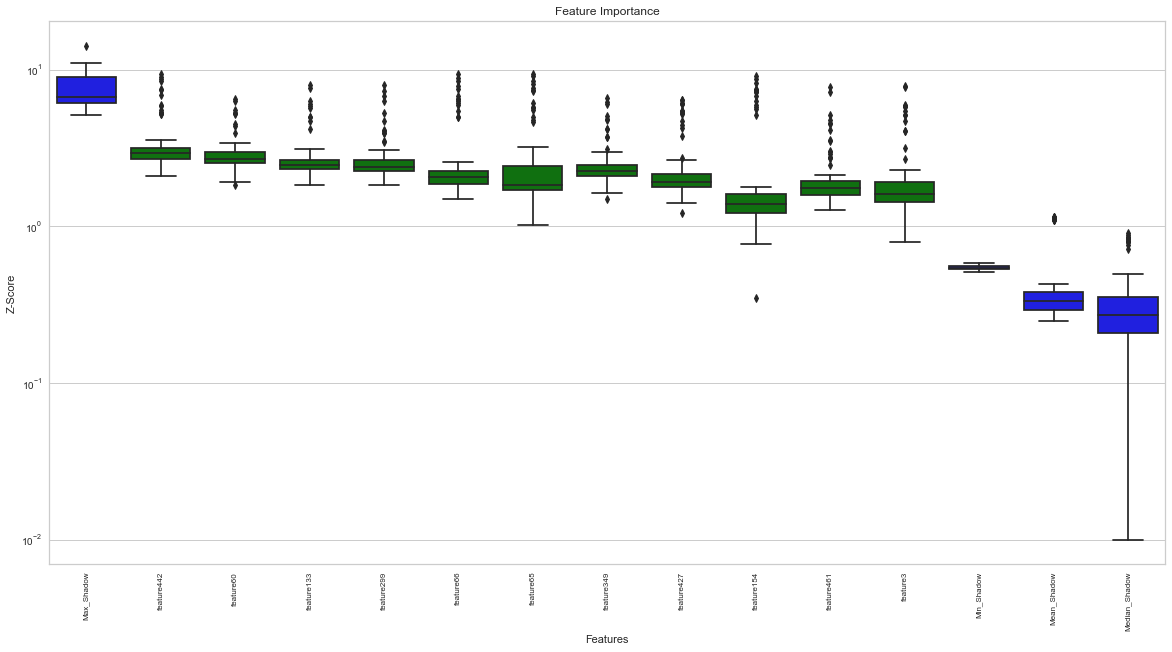

In [ ]:
X_trainshap= BorutaShapFeatureSelection(retransformed_train,y_train)

<AxesSubplot:>

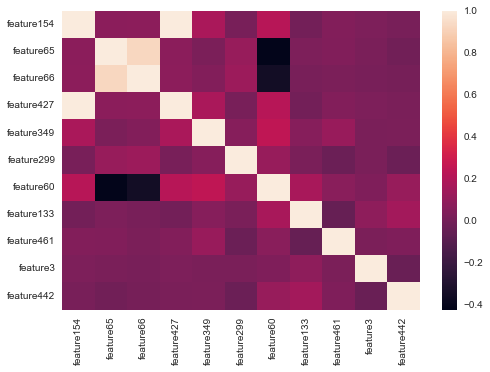

In [ ]:
X_trainshap.corr()
sns.heatmap(X_trainshap.corr())

# Checking

In [ ]:
'feature_ranking

SyntaxError: EOL while scanning string literal (Temp/ipykernel_17272/4140504645.py, line 1)

In [ ]:
from sklearn.inspection import permutation_importance

### Visualisation feature ranking

In [ ]:
# array to dataframe 
boruta_ranking = pd.DataFrame(data=feature_ranking, index=retransformed_train.columns.values, columns=['values'])

In [ ]:
#boruta_ranking
boruta_ranking

,values
feature1,3
feature2,358
feature3,260
feature4,132
feature5,436
...,...
feature586,203
feature587,191
feature588,39
feature589,178


In [ ]:
boruta_ranking['Variable'] = boruta_ranking.index
boruta_ranking.sort_values(['values'], ascending=True, inplace=True)

In [ ]:
boruta_ranking_30=boruta_ranking.loc[boruta_ranking['values']<=30]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x='values',y='Variable',data=feature_ranking)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()



AttributeError: 'numpy.ndarray' object has no attribute 'get'

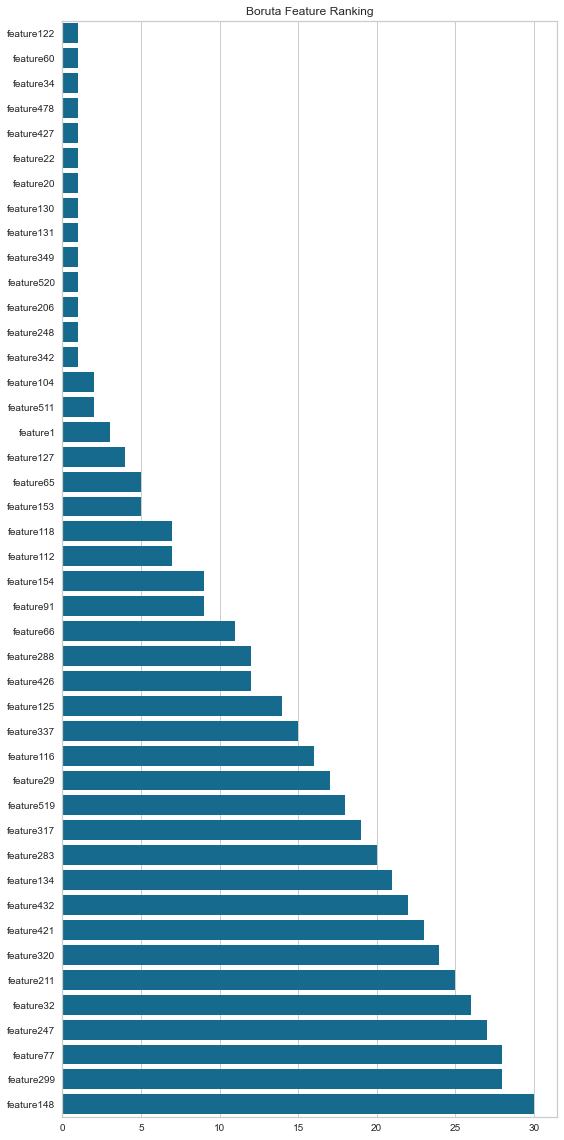

In [ ]:
'fig,ax = plt.subplots(figsize=(8,16))
ax = sns.barplot(x='values',y='Variable',data=boruta_ranking_30, color='b')
plt.title('Boruta Feature Ranking')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

Text(0, 0.5, '')

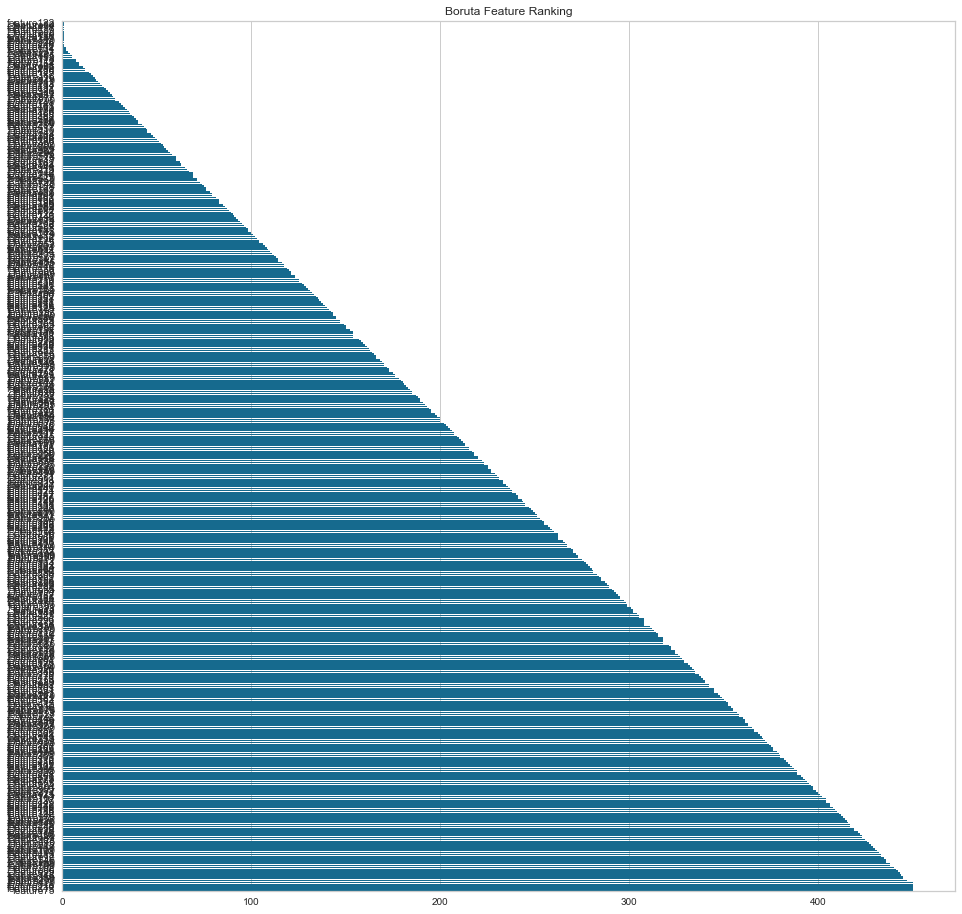

In [ ]:
fig,ax = plt.subplots(figsize=(16,16))
ax = sns.barplot(x='values',y='Variable',data=boruta_ranking, color='b')
plt.title('Boruta Feature Ranking')
plt.xlabel('')
plt.ylabel('')
#plt.tight_layout()

# Checking - manual Boruta without the function

In [ ]:
# 
# # prepare the data for boruta by fitting it to random forest Classifier 
#from sklearn.ensemble import RandomForestClassifier

# define random forest classifier
#forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
#forest.fit(imputed_train, y_train)
#iteration=200
# define Boruta feature selection method
#feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1,max_iter=iteration)

# find all relevant features
#feat_selector.fit(np.array(imputed_train),np.array(y_train))
#print("Ranking: ",feat_selector.ranking_)          
#print("No. of significant features: ", feat_selector.n_features_) 
#feat_selector.support_
#green_area = imputed_train.columns[feat_selector.support_].to_list()
#blue_area = imputed_train.columns[feat_selector.ranking_].to_list()
#X_best_features= feat_selector.transform(imputed_train.to_numpy())

# Preparation of test data

## reducing dimensionality

### missing values 

In [ ]:
x_test

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
1044,3031.22,2538.56,2211.5222,1079.7336,0.8126,100.0,105.1278,0.1190,1.4615,-0.0109,...,0.0060,67.6124,0.4998,0.0097,0.0028,1.9366,0.0257,0.0174,0.0060,67.6124
607,3032.07,2477.72,2172.4000,1148.4101,1.2614,100.0,102.4522,0.1227,1.4444,-0.0014,...,NaN,NaN,0.5027,0.0243,0.0047,4.8336,0.0199,0.0159,0.0048,79.7752
1332,3045.48,2408.85,2223.0444,1194.5986,1.2016,100.0,112.5811,0.1229,1.3838,-0.0125,...,NaN,NaN,0.4990,0.0137,0.0032,2.7392,0.0230,0.0210,0.0053,91.4264
1220,2973.99,2574.34,2226.4667,1591.2235,2.1717,100.0,90.3111,0.1219,1.4844,-0.0288,...,0.0032,54.1279,0.5030,0.0113,0.0035,2.2398,0.0207,0.0112,0.0032,54.1279
859,2919.71,2420.32,2134.7445,1244.2899,1.1827,100.0,99.5133,0.1249,1.3331,-0.0126,...,NaN,NaN,0.4938,0.0106,0.0028,2.1418,0.0220,0.0143,0.0045,65.2186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2998.01,2479.77,2189.9667,1046.6212,0.8662,100.0,102.3622,0.1208,1.3952,-0.0198,...,NaN,NaN,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601
1545,3100.19,2490.60,2212.8445,1068.5644,1.7835,100.0,113.8833,0.1249,1.4294,-0.0014,...,0.0070,402.6874,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874
54,2950.46,2398.44,2180.6778,1230.6762,1.4095,100.0,103.3778,0.1205,1.6486,-0.0239,...,0.0019,21.9917,0.4967,0.0152,0.0040,3.0587,0.0247,0.0054,0.0019,21.9917
1051,3012.45,2422.48,2208.5222,1838.7054,1.1571,100.0,95.2056,0.1249,1.4939,0.0096,...,NaN,NaN,0.4979,0.0120,0.0030,2.4101,0.0084,0.0097,0.0038,116.1088


In [ ]:
x_train_na

,Missing_Records,Percentage (%)
feature293,1144,91.300878
feature158,1144,91.300878
feature159,1144,91.300878
feature294,1144,91.300878
feature221,1072,85.554669
feature86,1072,85.554669
feature359,1072,85.554669
feature493,1072,85.554669


In [ ]:
x_test_na=x_test.drop(axis=1, columns=x_train_na.index)

In [ ]:
x_test_na

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
1044,3031.22,2538.56,2211.5222,1079.7336,0.8126,100.0,105.1278,0.1190,1.4615,-0.0109,...,0.0060,67.6124,0.4998,0.0097,0.0028,1.9366,0.0257,0.0174,0.0060,67.6124
607,3032.07,2477.72,2172.4000,1148.4101,1.2614,100.0,102.4522,0.1227,1.4444,-0.0014,...,NaN,NaN,0.5027,0.0243,0.0047,4.8336,0.0199,0.0159,0.0048,79.7752
1332,3045.48,2408.85,2223.0444,1194.5986,1.2016,100.0,112.5811,0.1229,1.3838,-0.0125,...,NaN,NaN,0.4990,0.0137,0.0032,2.7392,0.0230,0.0210,0.0053,91.4264
1220,2973.99,2574.34,2226.4667,1591.2235,2.1717,100.0,90.3111,0.1219,1.4844,-0.0288,...,0.0032,54.1279,0.5030,0.0113,0.0035,2.2398,0.0207,0.0112,0.0032,54.1279
859,2919.71,2420.32,2134.7445,1244.2899,1.1827,100.0,99.5133,0.1249,1.3331,-0.0126,...,NaN,NaN,0.4938,0.0106,0.0028,2.1418,0.0220,0.0143,0.0045,65.2186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2998.01,2479.77,2189.9667,1046.6212,0.8662,100.0,102.3622,0.1208,1.3952,-0.0198,...,NaN,NaN,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601
1545,3100.19,2490.60,2212.8445,1068.5644,1.7835,100.0,113.8833,0.1249,1.4294,-0.0014,...,0.0070,402.6874,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874
54,2950.46,2398.44,2180.6778,1230.6762,1.4095,100.0,103.3778,0.1205,1.6486,-0.0239,...,0.0019,21.9917,0.4967,0.0152,0.0040,3.0587,0.0247,0.0054,0.0019,21.9917
1051,3012.45,2422.48,2208.5222,1838.7054,1.1571,100.0,95.2056,0.1249,1.4939,0.0096,...,NaN,NaN,0.4979,0.0120,0.0030,2.4101,0.0084,0.0097,0.0038,116.1088


#### filter features of x_train_new only rather than choosing threshold

In [ ]:
x_train_new
#x_test_new= x_test[]

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
443,3079.77,2354.51,2207.0444,1269.6078,1.7571,100.0,97.0189,0.1221,1.4607,0.0155,...,0.0059,68.7444,0.5001,0.0110,0.0034,2.1899,0.0282,0.0194,0.0059,68.7444
760,3001.36,2491.23,2155.3111,918.2161,1.2753,100.0,105.0478,0.1227,1.4206,-0.0052,...,NaN,NaN,0.4943,0.0199,0.0042,4.0318,0.0169,0.0276,0.0081,163.9998
479,3042.78,2377.89,2173.4556,1433.6732,1.0304,100.0,110.5422,0.1245,1.4964,0.0204,...,NaN,NaN,0.4962,0.0114,0.0034,2.2877,0.0208,0.0287,0.0091,138.2861
362,3018.64,2401.80,2224.0000,1510.0797,1.5611,100.0,99.8300,0.1199,1.4428,-0.0110,...,0.0038,49.7490,0.5047,0.0101,0.0031,1.9927,0.0284,0.0141,0.0038,49.7490
662,3020.29,2433.99,2217.8111,1744.7771,0.9618,100.0,100.1789,0.1218,1.4950,-0.0097,...,NaN,NaN,0.5010,0.0147,0.0036,2.9338,0.0165,0.0114,0.0043,68.9871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,3057.31,2481.53,2214.9333,1663.7024,1.0203,100.0,100.4456,0.1247,1.4830,-0.0328,...,NaN,NaN,0.5037,0.0175,0.0039,3.4736,0.0263,0.0117,0.0033,44.3686
821,3009.71,2565.53,2224.6778,1308.6479,1.3907,100.0,101.1333,0.1208,1.4440,-0.0079,...,NaN,NaN,0.4979,0.0078,0.0024,1.5724,0.0275,0.0215,0.0076,78.1199
213,3034.34,2631.47,2179.0445,2028.2208,1.5552,100.0,95.4256,0.1234,1.4281,0.0049,...,NaN,NaN,0.4968,0.0128,0.0035,2.5829,0.0298,0.0116,0.0039,38.9781
1556,3025.21,2503.30,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3687,-0.0070,...,0.0016,46.1076,0.5019,0.0158,0.0043,3.1428,0.0120,0.0055,0.0016,46.1076


### constant volatility 

In [ ]:
x_train_new_eda[x_train_new_eda['std']==0]
x_train_new_std= x_train_new_eda[x_train_new_eda["std"] == 0]
x_train_new_std

,count,mean,std,min,25%,50%,75%,max
feature6,1243.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0
feature14,1251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature43,1253.0,70.0,0.0,70.0,70.0,70.0,70.0,70.0
feature50,1253.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
feature53,1253.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
feature535,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature536,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature537,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature538,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x_test_std=x_test_na.drop(axis=1, columns=x_train_new_std.index)

In [ ]:
x_test_std

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
1044,3031.22,2538.56,2211.5222,1079.7336,0.8126,105.1278,0.1190,1.4615,-0.0109,0.0140,...,0.0060,67.6124,0.4998,0.0097,0.0028,1.9366,0.0257,0.0174,0.0060,67.6124
607,3032.07,2477.72,2172.4000,1148.4101,1.2614,102.4522,0.1227,1.4444,-0.0014,0.0001,...,NaN,NaN,0.5027,0.0243,0.0047,4.8336,0.0199,0.0159,0.0048,79.7752
1332,3045.48,2408.85,2223.0444,1194.5986,1.2016,112.5811,0.1229,1.3838,-0.0125,0.0073,...,NaN,NaN,0.4990,0.0137,0.0032,2.7392,0.0230,0.0210,0.0053,91.4264
1220,2973.99,2574.34,2226.4667,1591.2235,2.1717,90.3111,0.1219,1.4844,-0.0288,-0.0029,...,0.0032,54.1279,0.5030,0.0113,0.0035,2.2398,0.0207,0.0112,0.0032,54.1279
859,2919.71,2420.32,2134.7445,1244.2899,1.1827,99.5133,0.1249,1.3331,-0.0126,0.0076,...,NaN,NaN,0.4938,0.0106,0.0028,2.1418,0.0220,0.0143,0.0045,65.2186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2998.01,2479.77,2189.9667,1046.6212,0.8662,102.3622,0.1208,1.3952,-0.0198,0.0026,...,NaN,NaN,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601
1545,3100.19,2490.60,2212.8445,1068.5644,1.7835,113.8833,0.1249,1.4294,-0.0014,0.0135,...,0.0070,402.6874,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874
54,2950.46,2398.44,2180.6778,1230.6762,1.4095,103.3778,0.1205,1.6486,-0.0239,0.0031,...,0.0019,21.9917,0.4967,0.0152,0.0040,3.0587,0.0247,0.0054,0.0019,21.9917
1051,3012.45,2422.48,2208.5222,1838.7054,1.1571,95.2056,0.1249,1.4939,0.0096,0.0071,...,NaN,NaN,0.4979,0.0120,0.0030,2.4101,0.0084,0.0097,0.0038,116.1088


### Outlier treatment of test data

In [ ]:
x_test_3s=x_test_std.copy()
zscore(x_test_3s,x_test_3s.columns,3)

In [ ]:
x_test_3s

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
1044,3031.22,2538.56,2211.5222,1079.7336,0.8126,105.1278,0.1190,1.4615,-0.0109,0.0140,...,0.0060,67.612400,0.4998,0.0097,0.0028,1.9366,0.0257,0.0174,0.0060,67.6124
607,3032.07,2477.72,2172.4000,1148.4101,1.2614,102.4522,0.1227,1.4444,-0.0014,0.0001,...,NaN,NaN,0.5027,0.0243,0.0047,4.8336,0.0199,0.0159,0.0048,79.7752
1332,3045.48,2408.85,2223.0444,1194.5986,1.2016,112.5811,0.1229,1.3838,-0.0125,0.0073,...,NaN,NaN,0.4990,0.0137,0.0032,2.7392,0.0230,0.0210,0.0053,91.4264
1220,2973.99,2574.34,2226.4667,1591.2235,2.1717,90.3111,0.1219,1.4844,-0.0288,-0.0029,...,0.0032,54.127900,0.5030,0.0113,0.0035,2.2398,0.0207,0.0112,0.0032,54.1279
859,2919.71,2420.32,2134.7445,1244.2899,1.1827,99.5133,0.1249,1.3331,-0.0126,0.0076,...,NaN,NaN,0.4938,0.0106,0.0028,2.1418,0.0220,0.0143,0.0045,65.2186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2998.01,2479.77,2189.9667,1046.6212,0.8662,102.3622,0.1208,1.3952,-0.0198,0.0026,...,NaN,NaN,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601
1545,3100.19,2490.60,2212.8445,1068.5644,1.7835,113.8833,0.1249,1.4294,-0.0014,0.0135,...,0.0070,355.944816,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874
54,2950.46,2398.44,2180.6778,1230.6762,1.4095,103.3778,0.1205,1.6486,-0.0239,0.0031,...,0.0019,21.991700,0.4967,0.0152,0.0040,3.0587,0.0247,0.0054,0.0019,21.9917
1051,3012.45,2422.48,2208.5222,1838.7054,1.1571,95.2056,0.1249,1.4939,0.0096,0.0071,...,NaN,NaN,0.4979,0.0120,0.0030,2.4101,0.0084,0.0097,0.0038,116.1088


## imputation

### KNN Imputation

In [ ]:
#no need to scale for test data
#x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test_3s), columns=x_test_3s.columns)
#x_test_scaled

In [ ]:
x_test_3s

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
1044,3031.22,2538.56,2211.5222,1079.7336,0.8126,105.1278,0.1190,1.4615,-0.0109,0.0140,...,0.0060,67.612400,0.4998,0.0097,0.0028,1.9366,0.0257,0.0174,0.0060,67.6124
607,3032.07,2477.72,2172.4000,1148.4101,1.2614,102.4522,0.1227,1.4444,-0.0014,0.0001,...,NaN,NaN,0.5027,0.0243,0.0047,4.8336,0.0199,0.0159,0.0048,79.7752
1332,3045.48,2408.85,2223.0444,1194.5986,1.2016,112.5811,0.1229,1.3838,-0.0125,0.0073,...,NaN,NaN,0.4990,0.0137,0.0032,2.7392,0.0230,0.0210,0.0053,91.4264
1220,2973.99,2574.34,2226.4667,1591.2235,2.1717,90.3111,0.1219,1.4844,-0.0288,-0.0029,...,0.0032,54.127900,0.5030,0.0113,0.0035,2.2398,0.0207,0.0112,0.0032,54.1279
859,2919.71,2420.32,2134.7445,1244.2899,1.1827,99.5133,0.1249,1.3331,-0.0126,0.0076,...,NaN,NaN,0.4938,0.0106,0.0028,2.1418,0.0220,0.0143,0.0045,65.2186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2998.01,2479.77,2189.9667,1046.6212,0.8662,102.3622,0.1208,1.3952,-0.0198,0.0026,...,NaN,NaN,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601
1545,3100.19,2490.60,2212.8445,1068.5644,1.7835,113.8833,0.1249,1.4294,-0.0014,0.0135,...,0.0070,355.944816,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874
54,2950.46,2398.44,2180.6778,1230.6762,1.4095,103.3778,0.1205,1.6486,-0.0239,0.0031,...,0.0019,21.991700,0.4967,0.0152,0.0040,3.0587,0.0247,0.0054,0.0019,21.9917
1051,3012.45,2422.48,2208.5222,1838.7054,1.1571,95.2056,0.1249,1.4939,0.0096,0.0071,...,NaN,NaN,0.4979,0.0120,0.0030,2.4101,0.0084,0.0097,0.0038,116.1088


In [ ]:
imputed_test = pd.DataFrame(knn.transform(x_test_3s), columns = x_test_3s.columns)

In [ ]:
imputed_test.isna().any().any()

False

In [ ]:
imputed_test

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,3031.22,2538.56,2211.5222,1079.7336,0.8126,105.1278,0.1190,1.4615,-0.0109,0.0140,...,0.006000,67.612400,0.4998,0.0097,0.0028,1.9366,0.0257,0.0174,0.0060,67.6124
1,3032.07,2477.72,2172.4000,1148.4101,1.2614,102.4522,0.1227,1.4444,-0.0014,0.0001,...,0.386595,0.392809,0.5027,0.0243,0.0047,4.8336,0.0199,0.0159,0.0048,79.7752
2,3045.48,2408.85,2223.0444,1194.5986,1.2016,112.5811,0.1229,1.3838,-0.0125,0.0073,...,0.292519,0.327173,0.4990,0.0137,0.0032,2.7392,0.0230,0.0210,0.0053,91.4264
3,2973.99,2574.34,2226.4667,1591.2235,2.1717,90.3111,0.1219,1.4844,-0.0288,-0.0029,...,0.003200,54.127900,0.5030,0.0113,0.0035,2.2398,0.0207,0.0112,0.0032,54.1279
4,2919.71,2420.32,2134.7445,1244.2899,1.1827,99.5133,0.1249,1.3331,-0.0126,0.0076,...,0.242541,0.225742,0.4938,0.0106,0.0028,2.1418,0.0220,0.0143,0.0045,65.2186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,2998.01,2479.77,2189.9667,1046.6212,0.8662,102.3622,0.1208,1.3952,-0.0198,0.0026,...,0.352786,0.500538,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601
310,3100.19,2490.60,2212.8445,1068.5644,1.7835,113.8833,0.1249,1.4294,-0.0014,0.0135,...,0.007000,355.944816,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874
311,2950.46,2398.44,2180.6778,1230.6762,1.4095,103.3778,0.1205,1.6486,-0.0239,0.0031,...,0.001900,21.991700,0.4967,0.0152,0.0040,3.0587,0.0247,0.0054,0.0019,21.9917
312,3012.45,2422.48,2208.5222,1838.7054,1.1571,95.2056,0.1249,1.4939,0.0096,0.0071,...,0.457152,0.523901,0.4979,0.0120,0.0030,2.4101,0.0084,0.0097,0.0038,116.1088


## Unscaling of imputed test and filtering the features of test dataset

In [ ]:
X_test = imputed_test.filter(final_features)

In [ ]:
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_3s), columns=x_train_3s.columns)

In [ ]:
X_test

,feature60,feature65,feature66,feature154,feature268,feature289,feature342,feature427,feature442,feature476,feature540,feature563
0,-1.2400,21.2400,28.1969,0.0143,0.1082,0.0046,3.4391,1.4793,1.1623,3.9269,4.3752,264.272000
1,-4.1518,24.1518,30.4891,0.0071,0.0342,0.0025,4.7775,0.7327,0.7663,4.6798,1.4685,0.583178
2,-5.1491,25.1491,33.1448,0.0093,0.0326,0.0032,2.7074,0.9544,0.5858,3.0835,1.4329,270.432000
3,-5.6500,25.6500,31.1416,0.0052,0.0347,0.0018,1.7046,0.5319,0.9136,3.3519,1.5727,251.964000
4,5.3973,16.3450,20.2491,0.0096,0.0779,0.0031,2.4584,0.9850,0.8834,5.1716,3.4104,266.352000
...,...,...,...,...,...,...,...,...,...,...,...,...
309,-1.4027,21.4027,28.4909,0.0142,0.0777,0.0048,1.7381,1.4588,0.7053,4.5614,3.4346,268.650000
310,4.6964,15.3036,21.7822,0.0087,0.0856,0.0028,2.0250,0.8921,0.7584,3.7902,3.7409,252.666000
311,20.0455,19.9545,26.3171,0.0123,0.0284,0.0046,2.5763,1.2708,0.7898,4.3776,1.2241,264.596000
312,-2.1409,22.1409,27.9241,0.0048,0.1032,0.0015,2.0725,0.4862,0.7724,4.3990,4.2568,254.388000


# Balancing 

In [ ]:
def Sampling(X_train, y_train, sampler):
    
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
        
        
    #Random under Sampling
    if sampler == "randomunder":
        sampler = RandomUnderSampler(random_state=100)

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    counter = Counter(y_resampled)
    print(counter)
    return X_resampled, y_resampled

In [ ]:
X_resampled, y_resampled = Sampling(X_train, y_train,'SMOTE')

Counter({-1: 1170, 1: 1170})


In [ ]:
X_resampled

,feature60,feature65,feature66,feature154,feature268,feature289,feature342,feature427,feature442,feature476,feature540,feature563
0,0.699100,19.300900,23.221600,0.012700,0.082800,0.004200,2.654700,1.315500,0.963900,4.517300,3.485300,267.070000
1,-1.417300,21.417300,27.271600,0.006500,0.102000,0.002200,2.098900,0.659300,0.842700,4.294900,4.285900,250.084000
2,10.235500,9.764500,14.706100,0.014800,0.046100,0.005000,2.501200,1.540300,0.919300,4.489000,1.982200,264.272000
3,9.851800,30.148200,36.079100,0.015900,0.084500,0.005200,2.432900,1.642200,0.715800,4.850300,3.562900,268.690800
4,1.033600,18.966400,24.305700,0.007800,0.036200,0.002600,3.265300,0.800600,1.125500,4.992300,1.545600,260.161200
...,...,...,...,...,...,...,...,...,...,...,...,...
2335,23.706392,33.013900,44.494277,0.008961,0.043125,0.003035,9.841889,0.918361,0.929856,9.982089,1.861833,250.507264
2336,-2.051666,22.051666,28.650096,0.006170,0.112008,0.002021,1.670600,0.635210,0.708908,5.055864,4.906702,264.018092
2337,-0.182844,20.182844,27.285500,0.011555,0.021732,0.003874,3.085819,1.189970,0.529930,4.509766,0.970731,270.719943
2338,17.143594,22.856406,28.537601,0.013702,0.031908,0.004401,2.430568,1.409997,0.748290,3.010809,1.368225,258.848719


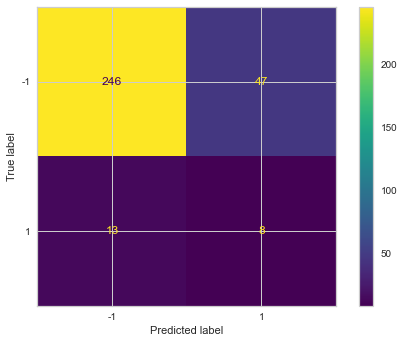

              precision    recall  f1-score   support

          -1       0.95      0.84      0.89       293
           1       0.15      0.38      0.21        21

    accuracy                           0.81       314
   macro avg       0.55      0.61      0.55       314
weighted avg       0.90      0.81      0.85       314



In [ ]:
# Plot confussion matrix
cm = confusion_matrix(y_test, y_pred_test, labels=rf_random.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_random.best_estimator_.classes_)
disp.plot()
plt.show()
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test)) 

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
print('f1_score', f1_score(X_test, y_pred_test))

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

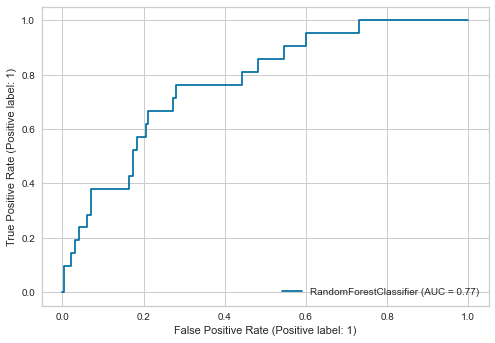

In [ ]:
# ROC curve
metrics.RocCurveDisplay.from_estimator(rf_random.best_estimator_, X_test, y_test)
plt.show()

# Build Model

## Random forest

### function for running model and printing accuracy score 

In [ ]:
def run_model(X, y,X_test,y_test):
    # building model before balancing data
    clf = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5)
    clf.fit(X,y)
    y_predicted_test= clf.predict(X_test)
    score1= accuracy_score(y_test, y_predicted_test)
    return score1

In [ ]:
#### run model on training data before sampling 
#run_model(imputed_train,y_train,imputed_test,y_test)
# train the model on feature selected X_train and y_train (without sampling ) and test it on prepared test data 
run_model(X_train,y_train,X_test,y_test)

ValueError: X has 14 features, but RandomForestClassifier is expecting 12 features as input.

In [ ]:
#### run model on training data after sampling 
run_model(X_resampled,y_resampled,X_test,y_test)

0.8407643312101911